In [1]:
!pip install transformers

In [2]:
!git clone https://github.com/princesegzy01/Jewellery-Classification.git

fatal: destination path 'Jewellery-Classification' already exists and is not an empty directory.


# Import Library

In [3]:
import torch
from transformers import ResNetForImageClassification
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Config

In [4]:
n_epochs = 20
learning_rate = 1e-3
patience = 3
weight_decay = 1e-4
batch_size = 32
data_dir = "/kaggle/working/Jewellery-Classification/dataset"
train_dir = data_dir + "/training/"
test_dir = data_dir + "/test/"

# Dataset

## Class Jewellery Dataset

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

object_labels = ["BRACELET", "EARRINGS", "NECKLACE", "RINGS", "WRISTWATCH"]

class JewelleryDataset(Dataset):
    def __init__(self, data_dir, labels = object_labels, transform = None):
        self.data_dir = data_dir
        self.labels = labels
        self.transform = transform
        self.images = []
        self.targets = []
        for i, label in enumerate(labels):
            sub_dir = os.path.join(data_dir, label)
            for file in os.listdir(sub_dir):
                if file.endswith(".jpg"):
                    self.images.append(os.path.join(sub_dir, file))
                    self.targets.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = Image.open(self.images[index])
        if image.mode != "RGB":
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        target = self.targets[index]
        target = torch.nn.functional.one_hot(torch.tensor(target), num_classes=len(self.labels))
        return image, target

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

## Dataloader

In [6]:
dataset_train = JewelleryDataset(data_dir=train_dir, transform=transform)
dataset_test = JewelleryDataset(data_dir=test_dir, transform=transform)

In [7]:
from torch.utils.data import random_split
import random
import torch

torch.manual_seed(42)
random.seed(42)

val_size = int(0.1 * len(dataset_train))
train_size = len(dataset_train) - val_size

train_dataset, val_dataset = random_split(dataset_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [8]:
for images, labels in valid_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32, 5])


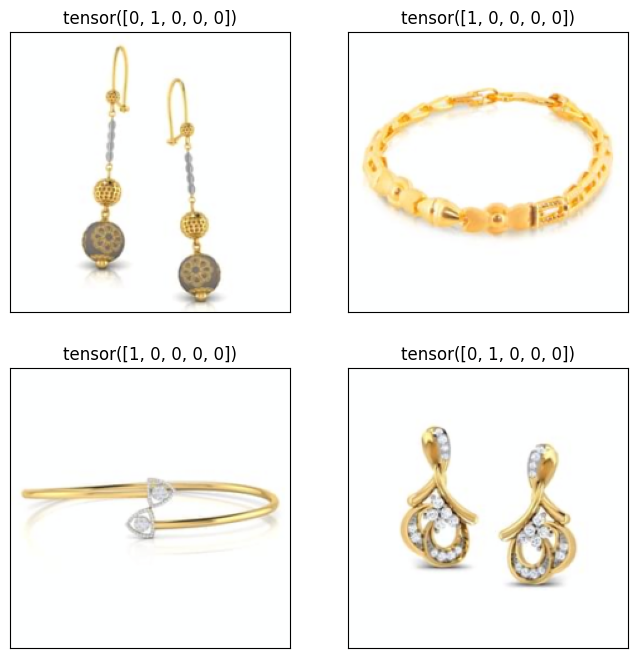

In [9]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

def tensor_to_image(tensor):
    tensor = tensor.clone().detach()
    if tensor.device == "cuda":
        tensor = tensor.cpu()
    array = tensor.numpy()
    array = array.transpose((1, 2, 0))
    array = array * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    array = array.clip(0, 1)
    return array

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image = tensor_to_image(images[i])
    label = labels[i]
    ax.imshow(image)
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## EarlyStopping

In [10]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

## Evalution

In [11]:
import torch
import numpy as np

def get_acc(predictions, targets):
    predictions = predictions.detach().cpu()
    targets = targets.detach().cpu()

    predictions_np = predictions.numpy()
    targets_np = targets.numpy()

    predicted_labels = np.argmax(predictions_np, axis=1)
    target_labels = np.argmax(targets_np, axis=1)

    correct_predictions = np.equal(predicted_labels, target_labels)

    accuracy = np.mean(correct_predictions.astype(float))
    return accuracy

# Model

In [12]:
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes = 5):
        super(ResNetClassifier, self).__init__()

        self.resnet = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

        for param in self.resnet.parameters():
            param.requires_grad = False

        in_features = self.resnet.classifier[-1].in_features
        new_classifier = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )
        self.resnet.classifier = new_classifier

    def forward(self, x):
        logits = self.resnet(x).logits
        return logits

# Training

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNetClassifier().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

early_stopping = EarlyStopping(patience = patience, verbose=True)

scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

In [14]:
list_loss = []
list_acc = []
list_dev_loss = []
list_dev_acc = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    for i, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, labels.to(float))

        acc = get_acc(output, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc
        pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss / (i+1):.4f}, Accuracy: {epoch_acc / (i+1):.4f}')

    # Step the learning rate scheduler
    scheduler.step()

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    list_loss.append(epoch_loss)
    list_acc.append(epoch_acc)

    dev_loss = 0.0
    dev_acc = 0.0

    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels.to(float))

            acc = get_acc(outputs, labels)

            dev_loss += loss.item()
            dev_acc += acc

    dev_loss /= len(valid_loader)
    dev_acc /= len(valid_loader)

    list_dev_loss.append(dev_loss)
    list_dev_acc.append(dev_acc)
    print(f"Epoch {epoch+1}/{n_epochs} | Training Loss: {epoch_loss:.6f} | Val Loss: {dev_loss:.6f} | Val Accuracy: {dev_acc:.4f}")

    early_stopping(dev_loss, model)
    if early_stopping.early_stop:
        n_epochs = epoch + 1
        print("Early stopping")
        break

Epoch [1/20], Loss: 1.0291, Accuracy: 0.6307: 100%|██████████| 38/38 [00:07<00:00,  4.85it/s]


Epoch 1/20 | Training Loss: 1.029090 | Val Loss: 0.587750 | Val Accuracy: 0.9042
Validation loss decreased (inf --> 0.587750).  Saving model ...


Epoch [2/20], Loss: 0.3827, Accuracy: 0.9177: 100%|██████████| 38/38 [00:06<00:00,  5.77it/s]


Epoch 2/20 | Training Loss: 0.382665 | Val Loss: 0.208354 | Val Accuracy: 0.9625
Validation loss decreased (0.587750 --> 0.208354).  Saving model ...


Epoch [3/20], Loss: 0.2085, Accuracy: 0.9497: 100%|██████████| 38/38 [00:06<00:00,  5.82it/s]


Epoch 3/20 | Training Loss: 0.208518 | Val Loss: 0.158731 | Val Accuracy: 0.9625
Validation loss decreased (0.208354 --> 0.158731).  Saving model ...


Epoch [4/20], Loss: 0.1571, Accuracy: 0.9580: 100%|██████████| 38/38 [00:06<00:00,  5.81it/s]


Epoch 4/20 | Training Loss: 0.157054 | Val Loss: 0.094482 | Val Accuracy: 0.9750
Validation loss decreased (0.158731 --> 0.094482).  Saving model ...


Epoch [5/20], Loss: 0.1248, Accuracy: 0.9720: 100%|██████████| 38/38 [00:06<00:00,  5.81it/s]


Epoch 5/20 | Training Loss: 0.124822 | Val Loss: 0.102801 | Val Accuracy: 0.9812


Epoch [6/20], Loss: 0.1256, Accuracy: 0.9671: 100%|██████████| 38/38 [00:06<00:00,  5.90it/s]


Epoch 6/20 | Training Loss: 0.125568 | Val Loss: 0.086182 | Val Accuracy: 0.9812
Validation loss decreased (0.094482 --> 0.086182).  Saving model ...


Epoch [7/20], Loss: 0.1073, Accuracy: 0.9728: 100%|██████████| 38/38 [00:06<00:00,  5.88it/s]


Epoch 7/20 | Training Loss: 0.107328 | Val Loss: 0.084777 | Val Accuracy: 0.9812
Validation loss decreased (0.086182 --> 0.084777).  Saving model ...


Epoch [8/20], Loss: 0.1126, Accuracy: 0.9720: 100%|██████████| 38/38 [00:06<00:00,  5.87it/s]


Epoch 8/20 | Training Loss: 0.112557 | Val Loss: 0.077974 | Val Accuracy: 0.9812
Validation loss decreased (0.084777 --> 0.077974).  Saving model ...


Epoch [9/20], Loss: 0.1070, Accuracy: 0.9745: 100%|██████████| 38/38 [00:06<00:00,  5.92it/s]


Epoch 9/20 | Training Loss: 0.107049 | Val Loss: 0.081926 | Val Accuracy: 0.9812


Epoch [10/20], Loss: 0.1017, Accuracy: 0.9778: 100%|██████████| 38/38 [00:06<00:00,  6.02it/s]


Epoch 10/20 | Training Loss: 0.101747 | Val Loss: 0.079279 | Val Accuracy: 0.9812


Epoch [11/20], Loss: 0.1176, Accuracy: 0.9704: 100%|██████████| 38/38 [00:06<00:00,  5.97it/s]


Epoch 11/20 | Training Loss: 0.117616 | Val Loss: 0.074540 | Val Accuracy: 0.9812
Validation loss decreased (0.077974 --> 0.074540).  Saving model ...


Epoch [12/20], Loss: 0.1066, Accuracy: 0.9769: 100%|██████████| 38/38 [00:06<00:00,  5.75it/s]


Epoch 12/20 | Training Loss: 0.106642 | Val Loss: 0.078494 | Val Accuracy: 0.9938


Epoch [13/20], Loss: 0.1096, Accuracy: 0.9762: 100%|██████████| 38/38 [00:06<00:00,  5.86it/s]


Epoch 13/20 | Training Loss: 0.109626 | Val Loss: 0.072689 | Val Accuracy: 0.9875
Validation loss decreased (0.074540 --> 0.072689).  Saving model ...


Epoch [14/20], Loss: 0.1031, Accuracy: 0.9819: 100%|██████████| 38/38 [00:06<00:00,  5.84it/s]


Epoch 14/20 | Training Loss: 0.103126 | Val Loss: 0.077284 | Val Accuracy: 0.9938


Epoch [15/20], Loss: 0.1050, Accuracy: 0.9802: 100%|██████████| 38/38 [00:06<00:00,  5.86it/s]


Epoch 15/20 | Training Loss: 0.105042 | Val Loss: 0.073712 | Val Accuracy: 0.9812


Epoch [16/20], Loss: 0.1256, Accuracy: 0.9654: 100%|██████████| 38/38 [00:06<00:00,  5.84it/s]


Epoch 16/20 | Training Loss: 0.125640 | Val Loss: 0.075975 | Val Accuracy: 0.9875
Early stopping


# Test Model

In [15]:
y_true_all = []
y_pred_all = []
test_acc = 0.0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        acc = get_acc(outputs, labels)
        test_acc += acc

        y_true_all.extend(torch.argmax(labels.cpu(), dim=1).numpy())
        y_pred_all.extend(torch.argmax(outputs.cpu(), dim=1).numpy())

test_acc /= len(test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8816


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_true_all, y_pred_all, target_names = object_labels, digits=4, zero_division=0))

              precision    recall  f1-score   support

    BRACELET     0.8113    0.9149    0.8600        47
    EARRINGS     0.7455    0.9318    0.8283        44
    NECKLACE     0.9762    0.8200    0.8913        50
       RINGS     0.9310    0.7297    0.8182        37
  WRISTWATCH     1.0000    0.9800    0.9899        50

    accuracy                         0.8816       228
   macro avg     0.8928    0.8753    0.8775       228
weighted avg     0.8956    0.8816    0.8824       228



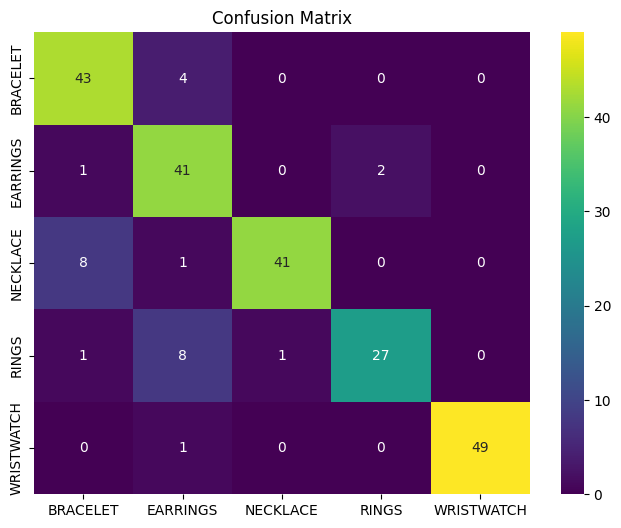

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True,  cmap='viridis', xticklabels=object_labels, yticklabels=object_labels)
plt.title('Confusion Matrix')
plt.show()

## Plot

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

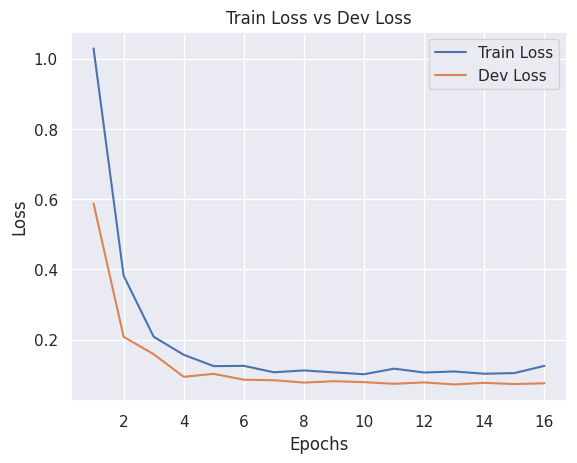

In [18]:
data = {
    "Epochs": list(range(1, n_epochs + 1)),
    "Train Loss": list_loss,
    "Train Acc": list_acc,
    "Dev Loss": list_dev_loss,
    "Dev Acc": list_dev_acc
}
df = pd.DataFrame(data)

sns.set(style="darkgrid")
sns.lineplot(data=df, x="Epochs", y="Train Loss", label="Train Loss")
sns.lineplot(data=df, x="Epochs", y="Dev Loss", label="Dev Loss")
plt.title('Train Loss vs Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

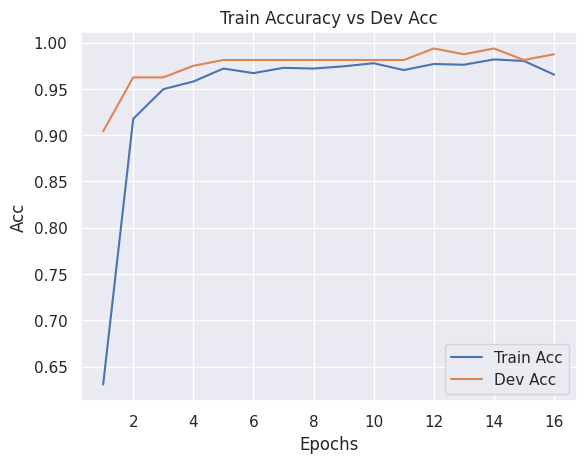

In [19]:
sns.lineplot(data=df, x="Epochs", y="Train Acc", label="Train Acc")
sns.lineplot(data=df, x="Epochs", y="Dev Acc", label="Dev Acc")
plt.title('Train Accuracy vs Dev Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()